# Importing Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor

In [35]:
import shap
from sklearn.tree import export_graphviz
import graphviz
import os
import shutil
from xgboost import to_graphviz
from google.colab import files

# Data Generation Using Physics Based Model

In [16]:
Re_values = np.linspace(2000, 20000, 100)  # Reynolds numbers
t_values = np.linspace(2, 10, 10)  # Twist ratios
p_values = np.linspace(0, 50, 5)  # Perforation percentage (0% to 50%)
n_values = np.arange(1, 6)  # Number of twisted tapes (1 to 5)

C, m, n_exp = 0.023, 0.8, 0.4
alpha, beta = 0.02, 0.03
sigma = 0.05
# Prandtl number
Pr_min, Pr_max = 3.5,7
A, B = 0.316, 0.25
gamma, delta = 0.01, 0.02

data = []
for Re in Re_values:
  for t in t_values:
    for p in p_values:
        for n in n_values:
          Pr = np.random.uniform(Pr_min, Pr_max)
          nu = C * (Re ** m) * (Pr ** n_exp) * (1 + alpha * p) * (1 + beta * n)
          nu *= (1 + np.random.normal(0, sigma))

          f = (A / (Re ** B)) * (1 + gamma * p) * (1 + delta * n)
          f *= (1 + np.random.normal(0, sigma))
          cf = f / 4
          data.append([round(Re,4), round(t,4), p, n, round(nu,4), round(cf,4)])

data = pd.DataFrame(data, columns=['Re', 'Twist Ratio', 'Perforation (%)', 'Number of Tapes', 'Nu', 'Skin Friction'])
data = data.sample(n=2000, random_state=42)
data.reset_index(drop=True, inplace=True)
data.head()

,Re,Twist Ratio,Perforation (%),Number of Tapes,Nu,Skin Friction
0,6909.0909,5.5556,37.5,4,111.1839,0.0136
1,19454.5455,2.0000,37.5,2,250.8541,0.0105
2,8909.0909,7.3333,37.5,4,139.6415,0.0111
3,11818.1818,6.4444,37.5,1,136.3988,0.0108
4,12181.8182,2.0000,37.5,4,187.7763,0.0119


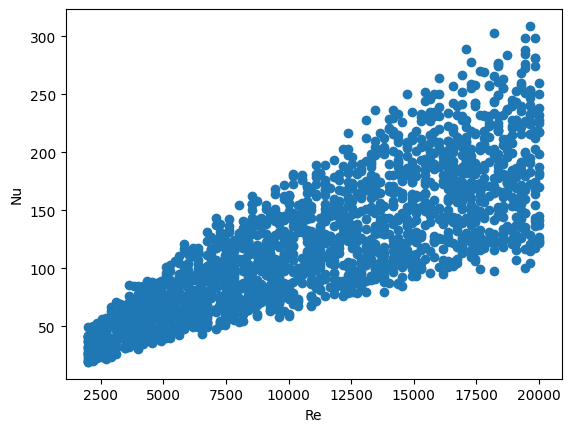

In [17]:
## clear positive correlation between Renoyld number and Nusselt number
plt.scatter(data['Re'],data['Nu'])
plt.xlabel('Re')
plt.ylabel('Nu')
plt.show()

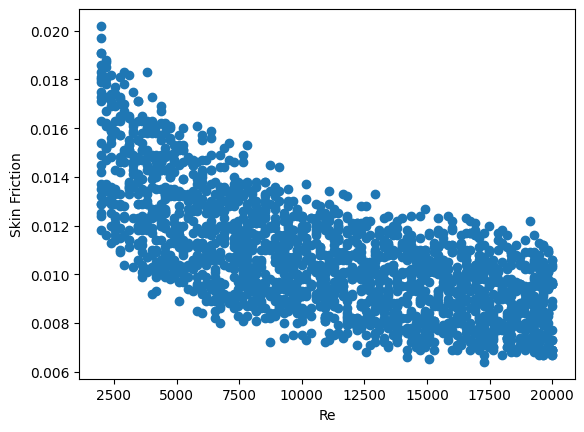

In [18]:
## negative correlation between Re and Skin Friction
plt.scatter(data['Re'],data['Skin Friction'])
plt.xlabel('Re')
plt.ylabel('Skin Friction')
plt.show()

In [19]:
correlation1 = data['Re'].corr(data['Nu'])
print(f"The correlation between Reynolds number (Re) and Nusselt number (Nu) is: {correlation1}")
correlation2 = data['Re'].corr(data['Skin Friction'])
print(f"The correlation between Reynolds number (Re) and Nusselt number (Nu) is: {correlation2}")

The correlation between Reynolds number (Re) and Nusselt number (Nu) is: 0.8133683987011547
The correlation between Reynolds number (Re) and Nusselt number (Nu) is: -0.6792678050437434


In [20]:
# min max scaler = (X-X_min)/(X_max-X_min)
max_nu = data["Nu"].max()
min_nu = data["Nu"].min()
max_cf = data["Skin Friction"].max()
min_cf = data["Skin Friction"].min()
print("maximum value for Nusselt number is : ",max_nu)
print("minimum value for Nusselt number is : ",min_nu)
print("maximum value for Skin Friction is : ",max_cf)
print("minimum value for Skin Friction is : ",min_cf)

maximum value for Nusselt number is :  309.0323
minimum value for Nusselt number is :  19.1259
maximum value for Skin Friction is :  0.0202
minimum value for Skin Friction is :  0.0064


# Conditional Tabular Generative Adversial Network

In [10]:
categorical_columns = ['Number of Tapes']
continuous_columns = ['Re', 'Twist Ratio', 'Perforation (%)', 'Nu', 'Skin Friction']
scaler = MinMaxScaler()
data_scaled = data.copy()
data_scaled[continuous_columns] = scaler.fit_transform(data[continuous_columns])

In [11]:
data_scaled.head()

,Re,Twist Ratio,Perforation (%),Number of Tapes,Nu,Skin Friction
0,0.272727,0.444450,0.75,4,0.262434,0.557047
1,0.969697,0.000000,0.75,2,0.713571,0.201342
2,0.383838,0.666663,0.75,4,0.352297,0.395973
3,0.545455,0.555550,0.75,1,0.427504,0.288591
4,0.565657,0.000000,0.75,4,0.553182,0.335570


In [34]:
ctgan = CTGAN(
    epochs=5000,
    batch_size=120,
    generator_dim=(512,256,128),
    discriminator_dim=(512,256,128),
    verbose=True
)
ctgan.fit(data_scaled, discrete_columns=categorical_columns)

Gen. (0.00) | Discrim. (0.00):   0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Gen. (0.16) | Discrim. (0.29): 100%|██████████| 5000/5000 [28:30<00:00,  2.92it/s]


In [35]:
samples = ctgan.sample(4000)
samples.head()

,Re,Twist Ratio,Perforation (%),Number of Tapes,Nu,Skin Friction
0,0.694122,0.949660,-0.002871,4,0.388326,0.071099
1,0.791407,0.057117,0.750885,2,0.689202,0.262205
2,0.049557,0.413119,0.507468,2,0.078737,0.451956
3,0.759208,0.330770,0.246720,1,0.356688,0.099367
4,0.433498,0.436532,0.253804,5,0.252830,0.178427


In [36]:
data_scaled.head()

,Re,Twist Ratio,Perforation (%),Number of Tapes,Nu,Skin Friction
0,0.272727,0.444450,0.75,4,0.235031,0.447552
1,0.969697,0.000000,0.75,2,0.687370,0.300699
2,0.383838,0.666663,0.75,4,0.358949,0.405594
3,0.545455,0.555550,0.75,1,0.389392,0.286713
4,0.565657,0.000000,0.75,4,0.471353,0.321678


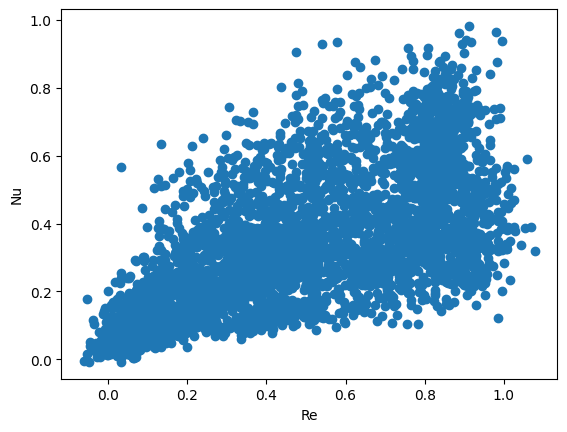

In [40]:
plt.scatter(samples['Re'],samples['Nu'])
plt.xlabel('Re')
plt.ylabel('Nu')
plt.show()

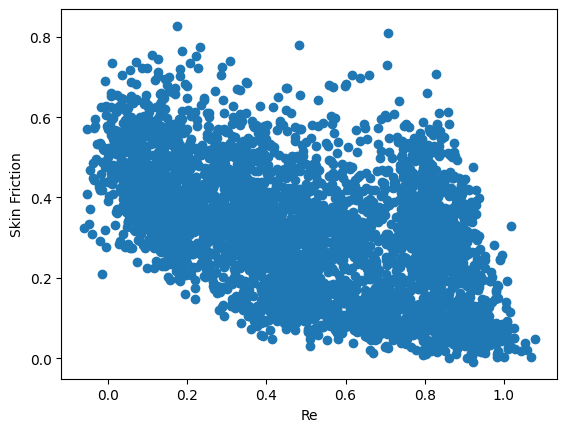

In [41]:
plt.scatter(samples['Re'],samples['Skin Friction'])
plt.xlabel('Re')
plt.ylabel('Skin Friction')
plt.show()

In [44]:
correlation1 = samples['Re'].corr(samples['Nu'])
print(f"The correlation between Reynolds number (Re) and Nusselt number (Nu) is: {correlation1}")
correlation2 = samples['Re'].corr(samples['Skin Friction'])
print(f"The correlation between Reynolds number (Re) and Nusselt number (Nu) is: {correlation2}")

The correlation between Reynolds number (Re) and Nusselt number (Nu) is: 0.6341848477462886
The correlation between Reynolds number (Re) and Nusselt number (Nu) is: -0.5121516369818033


# Comparision of Experimental and Synthetic Data

In [ ]:
# Use KS test, histograms, PCA, or t-SNE to compare real vs. synthetic

In [65]:
## KS Test
def run_ks_test(phys_df, gan_df, features):
    for col in features:
        stat, pval = ks_2samp(phys_df[col], gan_df[col])
        print(f"{col}: KS Stat = {stat:.4f}, p-value = {pval:.4f}")

run_ks_test(data_scaled, samples, ['Re', 'Number of Tapes', 'Nu','Skin Friction'])

Re: KS Stat = 0.0460, p-value = 0.0070
Number of Tapes: KS Stat = 0.0143, p-value = 0.9483
Nu: KS Stat = 0.0323, p-value = 0.1240
Skin Friction: KS Stat = 0.0643, p-value = 0.0000


In [ ]:
## Re - Small difference in distributions, but statistically significant
## Number of Tapes - distributions almost identical
## Nu - Good match
## Skin Friction - Moderate mismatch

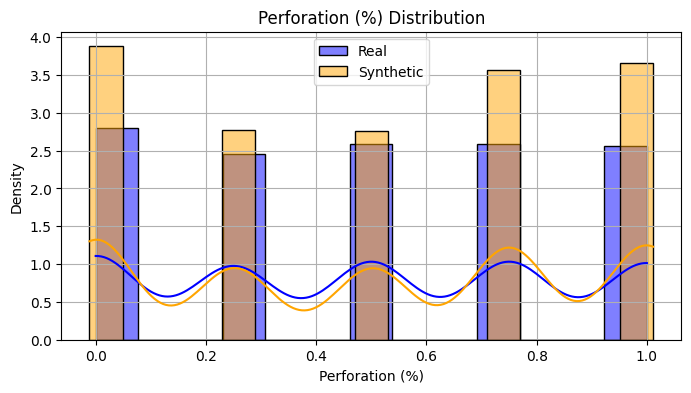

In [67]:
## histogram comparision of Perforation
plt.figure(figsize=(8, 4))
sns.histplot(data_scaled['Perforation (%)'], label='Real', color='blue', stat="density", kde=True)
sns.histplot(samples['Perforation (%)'], label='Synthetic', color='orange', stat="density", kde=True)
plt.title('Perforation (%) Distribution')
plt.legend()
plt.grid(True)
plt.show()

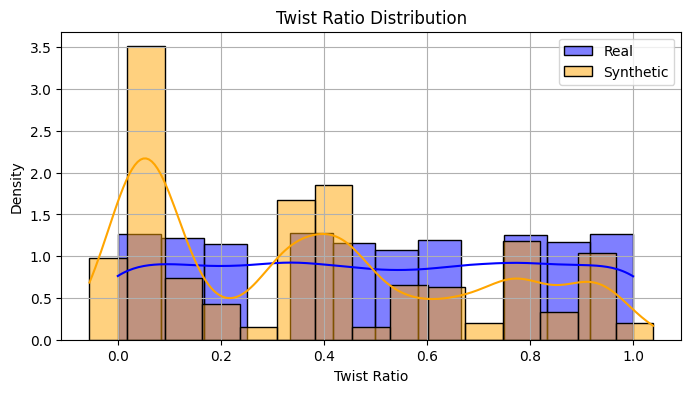

In [68]:
## histogram comparision of Twist Ratio
plt.figure(figsize=(8, 4))
sns.histplot(data_scaled['Twist Ratio'], label='Real', color='blue', stat="density", kde=True)
sns.histplot(samples['Twist Ratio'], label='Synthetic', color='orange', stat="density", kde=True)
plt.title('Twist Ratio Distribution')
plt.legend()
plt.grid(True)
plt.show()

In [69]:
pca=PCA(n_components=2)

In [70]:
data_pca=pca.fit_transform(data_scaled)
data_pca

array([[ 0.92761158,  0.26087947],
       [-1.07411836,  0.25309422],
       [ 0.92902406,  0.28269182],
       ...,
       [-0.06790852, -0.19623058],
       [-1.0711169 , -0.51801106],
       [-0.07429161, -0.5346149 ]])

Text(0.5, 1.0, 'Experimental Data')

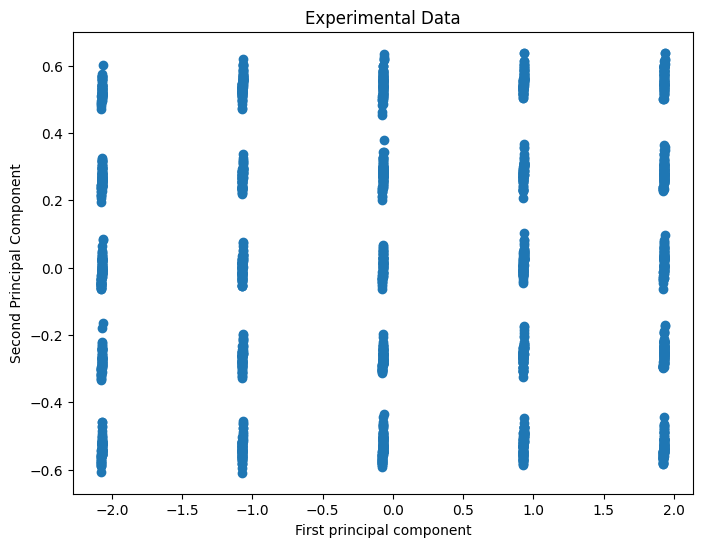

In [71]:
plt.figure(figsize=(8,6))
plt.scatter(data_pca[:,0],data_pca[:,1])
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.title('Experimental Data')

In [72]:
samples_pca=pca.fit_transform(samples)
samples_pca

array([[ 0.97191232, -0.67605373],
       [-1.02539793,  0.37964118],
       [-1.02641438, -0.02569   ],
       ...,
       [-1.02853199, -0.24828672],
       [ 0.97126496, -0.1988234 ],
       [-2.02281361, -0.22338304]])

Text(0, 0.5, 'Second Principal Component')

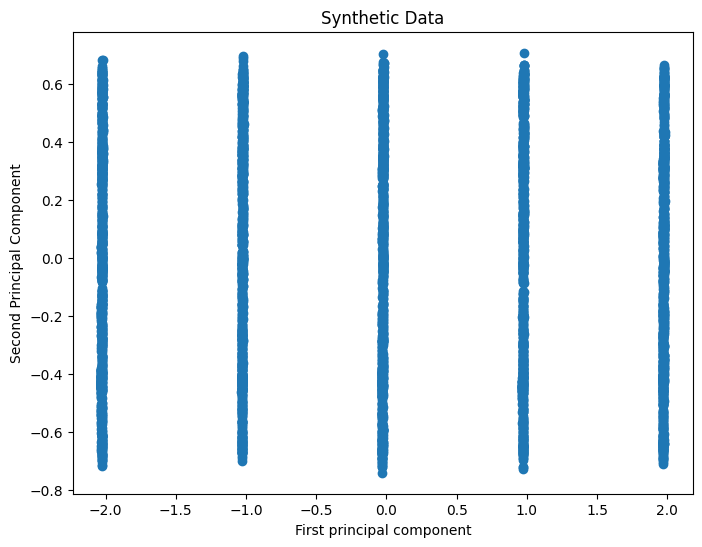

In [73]:
plt.figure(figsize=(8,6))
plt.title('Synthetic Data')
plt.scatter(samples_pca[:,0],samples_pca[:,1])
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

# Data Preperation for ML Model Training

In [9]:
df_synthetic = pd.read_csv("synthetic_data.csv")
df_synthetic.shape

(4000, 7)

In [10]:
df_synthetic.head()

,Unnamed: 0,Re,Twist Ratio,Perforation (%),Number of Tapes,Nu,Skin Friction
0,0,0.694122,0.949660,-0.002871,4,0.388326,0.071099
1,1,0.791407,0.057117,0.750885,2,0.689202,0.262205
2,2,0.049557,0.413119,0.507468,2,0.078737,0.451956
3,3,0.759208,0.330770,0.246720,1,0.356688,0.099367
4,4,0.433498,0.436532,0.253804,5,0.252830,0.178427


In [11]:
df_physical = pd.read_csv("exp_data.csv")
df_physical.shape

(2000, 7)

In [12]:
df_physical.head()

,Unnamed: 0,Re,Twist Ratio,Perforation (%),Number of Tapes,Nu,Skin Friction
0,0,0.272727,0.444450,0.75,4,0.235031,0.447552
1,1,0.969697,0.000000,0.75,2,0.687370,0.300699
2,2,0.383838,0.666663,0.75,4,0.358949,0.405594
3,3,0.545455,0.555550,0.75,1,0.389392,0.286713
4,4,0.565657,0.000000,0.75,4,0.471353,0.321678


In [13]:
df = pd.concat([df_physical, df_synthetic], axis=0)
df = df.sample(frac=1, random_state=10).reset_index(drop=True)
df = df.drop(columns=['Unnamed: 0'])
df.shape

(6000, 6)

In [14]:
df.head()

,Re,Twist Ratio,Perforation (%),Number of Tapes,Nu,Skin Friction
0,0.606061,1.000000,1.000000,5,0.575462,0.517483
1,0.356454,0.327624,0.747728,1,0.486483,0.288670
2,0.454545,0.222225,0.250000,1,0.259400,0.202797
3,0.474114,0.956930,0.999011,3,0.552426,0.465335
4,0.653239,0.791820,0.001377,4,0.331455,0.053542


# Nusselt Number Prediction

In [18]:
X = df.drop(columns=['Nu','Skin Friction'])
y = df['Nu']

In [19]:
X.head()

,Re,Twist Ratio,Perforation (%),Number of Tapes
0,0.606061,1.000000,1.000000,5
1,0.356454,0.327624,0.747728,1
2,0.454545,0.222225,0.250000,1
3,0.474114,0.956930,0.999011,3
4,0.653239,0.791820,0.001377,4


In [20]:
y.head()

,Nu
0,0.575462
1,0.486483
2,0.259400
3,0.552426
4,0.331455


In [21]:
max_nu,min_nu

(305.6929, 18.3953)

In [22]:
## y_scaled = (y-y_min)/(y_max-y_min)
## y = [y_scaled*(y_max-y_min)]+y_min
y = (y*(max_nu-min_nu))+min_nu
y.head()

,Nu
0,183.724109
1,158.160815
2,92.920224
3,177.105889
4,113.621481


In [23]:
y.max(),y.min()

(305.6929, 16.19777463863219)

In [24]:
X.head()

,Re,Twist Ratio,Perforation (%),Number of Tapes
0,0.606061,1.000000,1.000000,5
1,0.356454,0.327624,0.747728,1
2,0.454545,0.222225,0.250000,1
3,0.474114,0.956930,0.999011,3
4,0.653239,0.791820,0.001377,4


In [25]:
y.head()

,Nu
0,183.724109
1,158.160815
2,92.920224
3,177.105889
4,113.621481


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4200, 4), (1800, 4), (4200,), (1800,))

In [27]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [28]:
## model training overview
models = {
    "Decision Tree": DecisionTreeRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "XGBoost": XGBRegressor()

}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)
    print(list(models.keys())[i])
    print('==============Model performance for Training set================')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))
    print('======================================')
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    print('='*35)
    print("\n")

Decision Tree
==============Model performance for Training set================
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000
Model performance for Test set
- Root Mean Squared Error: 37.7675
- Mean Absolute Error: 27.0859
- R2 Score: 0.5428


Gradient Boosting
==============Model performance for Training set================
- Root Mean Squared Error: 25.1740
- Mean Absolute Error: 18.3601
- R2 Score: 0.8003
Model performance for Test set
- Root Mean Squared Error: 27.0154
- Mean Absolute Error: 19.6995
- R2 Score: 0.7661


AdaBoost
==============Model performance for Training set================
- Root Mean Squared Error: 29.9149
- Mean Absolute Error: 23.7364
- R2 Score: 0.7180
Model performance for Test set
- Root Mean Squared Error: 30.7164
- Mean Absolute Error: 24.4499
- R2 Score: 0.6976


XGBoost
==============Model performance for Training set================
- Root Mean Squared Error: 13.2250
- Mean Absolute Error: 9.7872
- R2 Score: 0.9449


In [29]:
## Decision tree is overfitting
## Adaboost lower R^2 value
## Xgboost also seems to be overfitting
## Most balanced is Gradient Boost so I am selecting Gradient Boost for Hyperparam tuning

In [89]:
## hyperparam tuning
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'learning_rate': [0.03, 0.04, 0.05, 0.06, 0.07],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', 0.8]
}

model = GradientBoostingRegressor()
random_search = RandomizedSearchCV(estimator=model,param_distributions=param_grid,n_iter=50,cv=5,scoring='neg_mean_squared_error',verbose=2,random_state=42,n_jobs=-1)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.03, 0.04, 0.05,
                                                          0.06, 0.07],
                                        'max_depth': [3, 4, 5, 6],
                                        'max_features': ['sqrt', 'log2', 0.8],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [3, 4, 5, 6],
                                        'n_estimators': [100, 150, 200, 250],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [91]:
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 4, 'learning_rate': 0.05}


In [83]:
## 'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 4, 'learning_rate': 0.05

In [30]:
model_nu = GradientBoostingRegressor(
    subsample=1.0,
    n_estimators=100,
    min_samples_split=3,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=4,
    learning_rate=0.05
)
model_nu.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, max_features='sqrt',
                          min_samples_split=3)

In [31]:
y_train_pred = model_nu.predict(X_train)
y_test_pred = model_nu.predict(X_test)

In [32]:
model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)
print('==============Model performance for Training set================')
print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
print("- R2 Score: {:.4f}".format(model_train_r2))
print('======================================')
print('Model performance for Test set')
print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
print("- R2 Score: {:.4f}".format(model_test_r2))
print('='*35)

==============Model performance for Training set================
- Root Mean Squared Error: 25.0622
- Mean Absolute Error: 18.3129
- R2 Score: 0.8021
Model performance for Test set
- Root Mean Squared Error: 26.8436
- Mean Absolute Error: 19.7123
- R2 Score: 0.7691


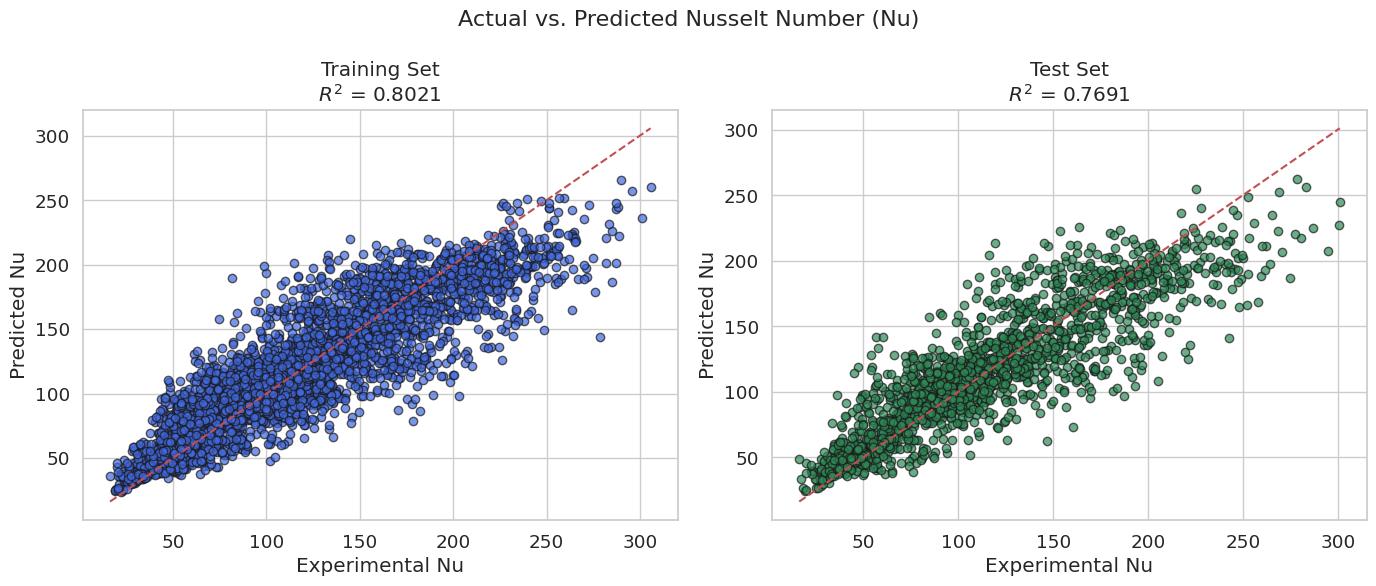

In [33]:
sns.set(style="whitegrid", font_scale=1.2)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].scatter(y_train, y_train_pred, color='royalblue', edgecolor='k', alpha=0.7)
axs[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
axs[0].set_title(f"Training Set\n$R^2$ = {r2_score(y_train, y_train_pred):.4f}")
axs[0].set_xlabel("Experimental Nu")
axs[0].set_ylabel("Predicted Nu")

axs[1].scatter(y_test, y_test_pred, color='seagreen', edgecolor='k', alpha=0.7)
axs[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axs[1].set_title(f"Test Set\n$R^2$ = {r2_score(y_test, y_test_pred):.4f}")
axs[1].set_xlabel("Experimental Nu")
axs[1].set_ylabel("Predicted Nu")

plt.suptitle("Actual vs. Predicted Nusselt Number (Nu)", fontsize=16)
plt.tight_layout()
plt.show()

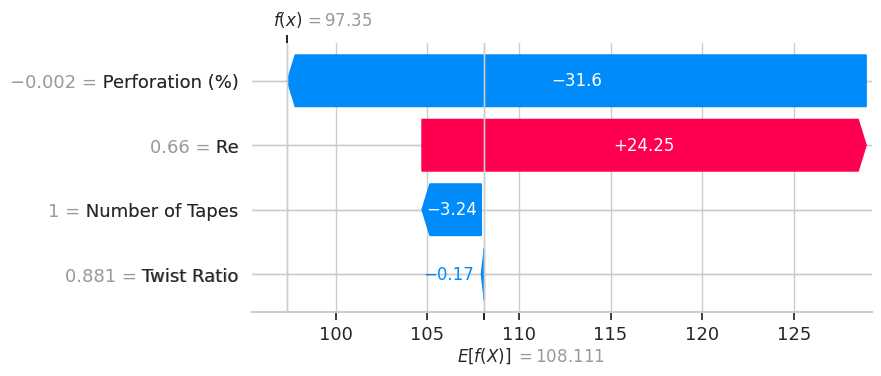

In [37]:
explainer = shap.Explainer(model_nu.predict, X_train)
shap_values = explainer(X_test[:1])
shap.plots.waterfall(shap_values[0])

In [38]:
## Perforation: -0.002, This has a strong negative impact it pulls the prediction down by 31.6 units
## low perforation reduces Nu significantly
## Re: 0.66 This contributes +24.25, increasing the Nu because a higher Re usually means more convective heat transfer.
## Number of Tapes	−3.24, Slight negative impact
## Twist Ratio -0.17 negative impact

In [41]:
total_trees = len(model_nu.estimators_)
print(f"Total number of trees: {total_trees}")

Total number of trees: 100


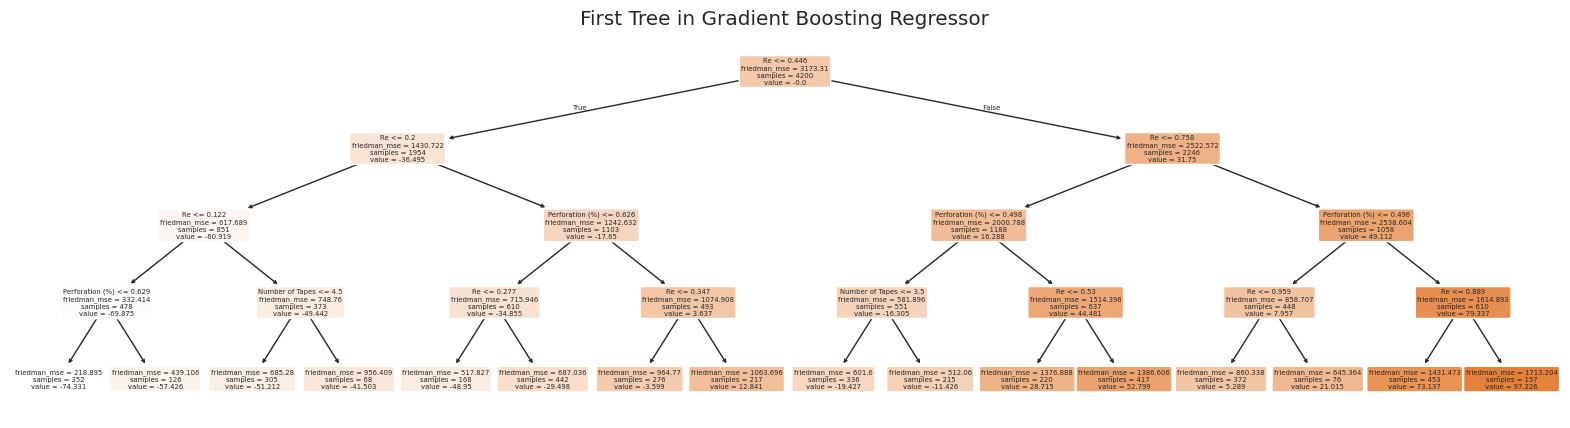

In [54]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 5))
plot_tree(model_nu.estimators_[0, 0], feature_names=X_train.columns, filled=True, rounded=True)
plt.title("First Tree in Gradient Boosting Regressor")
plt.show()

In [48]:
## download all the 100 trees
feature_names = X_train.columns.tolist()
for i in range(model_nu.n_estimators):
    dot_data = export_graphviz(
        model_nu.estimators_[i, 0],
        out_file=None,
        feature_names=feature_names,
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = graphviz.Source(dot_data)
    graph.render(f"tree_{i + 1}")

# Skin Friction Prediction

In [21]:
max_cf,min_cf

(0.0202, 0.0064)

In [22]:
df.head()

,Re,Twist Ratio,Perforation (%),Number of Tapes,Nu,Skin Friction
0,0.606061,1.000000,1.000000,5,0.575462,0.517483
1,0.356454,0.327624,0.747728,1,0.486483,0.288670
2,0.454545,0.222225,0.250000,1,0.259400,0.202797
3,0.474114,0.956930,0.999011,3,0.552426,0.465335
4,0.653239,0.791820,0.001377,4,0.331455,0.053542


In [23]:
X = df.drop(columns=['Nu','Skin Friction'])
y = df['Skin Friction']

In [24]:
X.head()

,Re,Twist Ratio,Perforation (%),Number of Tapes
0,0.606061,1.000000,1.000000,5
1,0.356454,0.327624,0.747728,1
2,0.454545,0.222225,0.250000,1
3,0.474114,0.956930,0.999011,3
4,0.653239,0.791820,0.001377,4


In [25]:
y.head()

,Skin Friction
0,0.517483
1,0.288670
2,0.202797
3,0.465335
4,0.053542


In [26]:
y = (y*(max_cf-min_cf))+min_cf
y.head()

,Skin Friction
0,0.013541
1,0.010384
2,0.009199
3,0.012822
4,0.007139


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4200, 4), (1800, 4), (4200,), (1800,))

In [31]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [36]:
## model training overview
models = {
    "Decision Tree": DecisionTreeRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "XGBoost": XGBRegressor()

}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)
    print(list(models.keys())[i])
    print('==============Model performance for Training set================')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))
    print('======================================')
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    print('='*35)
    print("\n")

Decision Tree
==============Model performance for Training set================
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000
Model performance for Test set
- Root Mean Squared Error: 0.0016
- Mean Absolute Error: 0.0012
- R2 Score: 0.5640


Gradient Boosting
==============Model performance for Training set================
- Root Mean Squared Error: 0.0010
- Mean Absolute Error: 0.0008
- R2 Score: 0.7924
Model performance for Test set
- Root Mean Squared Error: 0.0012
- Mean Absolute Error: 0.0009
- R2 Score: 0.7613


AdaBoost
==============Model performance for Training set================
- Root Mean Squared Error: 0.0013
- Mean Absolute Error: 0.0011
- R2 Score: 0.6814
Model performance for Test set
- Root Mean Squared Error: 0.0014
- Mean Absolute Error: 0.0011
- R2 Score: 0.6689


XGBoost
==============Model performance for Training set================
- Root Mean Squared Error: 0.0009
- Mean Absolute Error: 0.0007
- R2 Score: 0.8459
Model perfo

In [37]:
## Decision Tree : Overfit training data
## Gradient Boost : Good
## Adaboost : Good but not as Gradient Boost
## Xgboost : Slight overfitting but can be adjusted
## Xgboost will be better choice for hyperparam tuning

In [44]:
## Hyperparam Tuning
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.1, 1, 5, 10]
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=50,                      # Number of parameter settings sampled
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          random_state=42, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.3, 0.5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'n_estimators': [100, 200, 300, 500],
                                        'reg_alpha': [0, 0.1, 0.5, 1],
                                        'reg_lambda': [0.1, 1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [47]:
print("Best Parameters:\n", random_search.best_params_)

Best Parameters:
 {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}


In [48]:
## 'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8

In [28]:
model = XGBRegressor(
    subsample=1.0,
    reg_lambda=0.1,
    reg_alpha=0.0,
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    gamma=0.0,
    colsample_bytree=0.8
)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [29]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [32]:
model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)
print('==============Model performance for Training set================')
print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
print("- R2 Score: {:.4f}".format(model_train_r2))
print('======================================')
print('Model performance for Test set')
print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
print("- R2 Score: {:.4f}".format(model_test_r2))
print('='*35)

==============Model performance for Training set================
- Root Mean Squared Error: 0.0009
- Mean Absolute Error: 0.0007
- R2 Score: 0.8248
Model performance for Test set
- Root Mean Squared Error: 0.0011
- Mean Absolute Error: 0.0008
- R2 Score: 0.7642


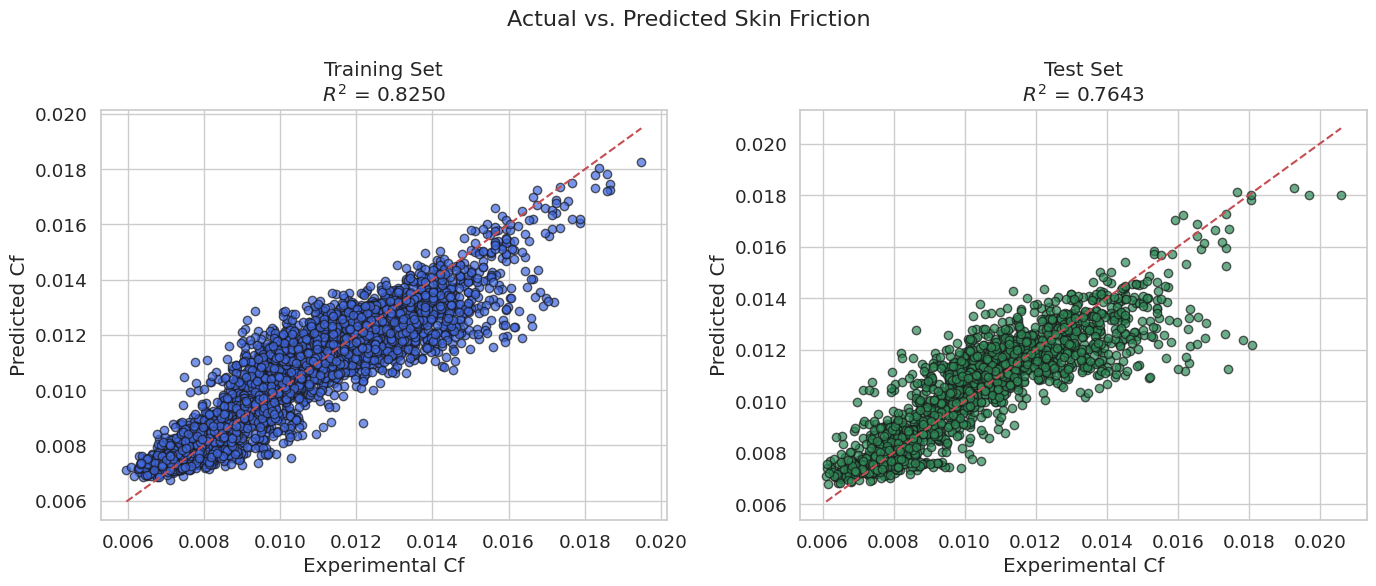

In [54]:
sns.set(style="whitegrid", font_scale=1.2)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].scatter(y_train, y_train_pred, color='royalblue', edgecolor='k', alpha=0.7)
axs[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
axs[0].set_title(f"Training Set\n$R^2$ = {r2_score(y_train, y_train_pred):.4f}")
axs[0].set_xlabel("Experimental Cf")
axs[0].set_ylabel("Predicted Cf")

axs[1].scatter(y_test, y_test_pred, color='seagreen', edgecolor='k', alpha=0.7)
axs[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axs[1].set_title(f"Test Set\n$R^2$ = {r2_score(y_test, y_test_pred):.4f}")
axs[1].set_xlabel("Experimental Cf")
axs[1].set_ylabel("Predicted Cf")

plt.suptitle("Actual vs. Predicted Skin Friction", fontsize=16)
plt.tight_layout()
plt.show()

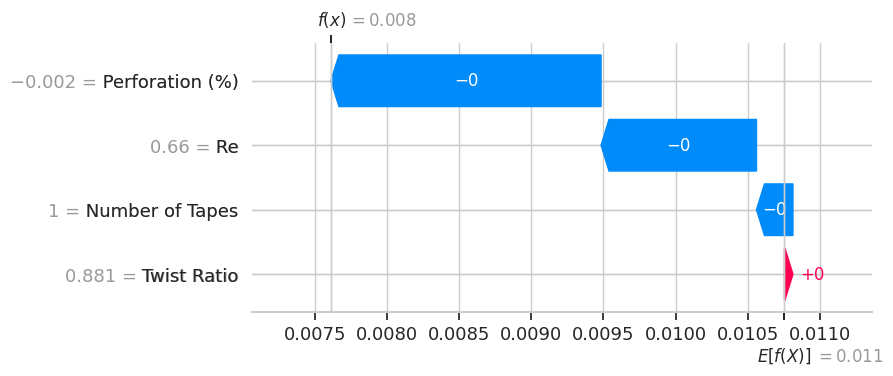

In [55]:
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_test[:1])
shap.plots.waterfall(shap_values[0])

In [56]:
## Perforation (%)	-0.002	Strong Negative Pushes Cf down significantly
## Re (Reynolds Number)	0.66	Moderate Negative Decreases Cf
## Number of Tapes	1	Slight Negative Minor downward effect
## Twist Ratio	0.881	Neutral to Slight Positive Almost no change

In [33]:
len(model.get_booster().get_dump())

500

In [34]:
# Create directory to store trees
os.makedirs("xgboost_tree_pdfs", exist_ok=True)
# Total number of trees
num_trees = len(model.get_booster().get_dump())
# Export each tree as PDF
for i in range(num_trees):
    dot = to_graphviz(model, num_trees=i, rankdir='LR')
    dot.render(f"xgboost_tree_pdfs/xgboost_tree_{i}", format='pdf')
# Zip the folder
shutil.make_archive("xgboost_tree_pdfs", 'zip', "xgboost_tree_pdfs")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
files.download("xgboost_tree_pdfs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>